# CAB420: Data Generators for Multi-Task Models
Ethan Goan, Dr Simon Denman (s.denman@qut.edu.au)

## Overview 

This is a quick demo on how to make a data generator that includes image augmentation for a multi output model, and may be of used for Q2 of assignment 1C.

### Note

The network we are making doesn't do anything usefull. It has two tasks, but they are both operating on the same data labels, so what it's really doing is the same thing twice. However, this does provide an example of how you can use augmentation in a multi-task model.

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Data

We'll just use Fashion MNIST, and we'll remove most of the samples too as we're using augmentation.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

# remove 95% of the data, just take every 20th element
x_train = x_train[1::20, :, :, :]
print(np.shape(x_train))
y_train = y_train[1::20, :]
print(np.shape(y_train))

(3000, 28, 28, 1)
(3000, 1)


## Creating a Data Generator

We need to create a custom generator for the sequence, which will allow us to output to augmented data and the multiple ground trth labels. 

This has largely been taken from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

If you wish to adapt this, the `__init__` and `__data_generation` methods are the most critical.

In [3]:
# Class for the data generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    # Input arguments are as follows:
    #  x:            our X data array that we'll augment
    #  y_one:        y labels for the first output
    #  y_two:        y labels for the second ouput
    #  data_aug:     our data augmentor
    #  batch_size:   the batch size to return from the generator
    #  dim:          size of images
    #  n_channels:   number of image channels
    #  shuffle:      flag to indicate if we should shuffle the data at the end of the epoch
    def __init__(self, x, y_one, y_two, data_aug,                 
                 batch_size=32, dim=(28,28), n_channels=1,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.x = x
        self.y_one = y_one
        self.y_two = y_two
        self.data_aug = data_aug
        self.list_IDs = np.arange(0, self.x.shape[0])
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    # Function to generate data. This will take in a list of sample indicies, and then for each
    # these apply augmentation, and return the augmented data and labels
    #
    # If you wish to check the mechanics out in more detail, you can uncomment the two print lines
    # which will show you the IDs that are being manipulated and help show what's going on - however
    # this will also generate a lot of output text during model training.
    #
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization - creating space for X and y data
#        print(list_IDs_temp)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # creating a list of empty arrays to hold our data labels. 
        # would initialise this for the number of output labels we have
        y = [np.empty((self.batch_size), dtype=int),
             np.empty((self.batch_size), dtype=int)]

        # Generate data, loop through the list of IDs we have and generate data for each in turn
        for i, ID in enumerate(list_IDs_temp):
#            print(ID)
            # apply random transformation based of our datagen instance
            X[i,] = self.data_aug.random_transform(self.x[ID,])
            # copy our y labels across
            y[0][i,] = self.y_one[ID]
            y[1][i,] = self.y_two[ID]
        return X, y

### Data Augmentation

We can use Keras' existing data augmentor here. We'll deliberately create some fairly wild and extreme augmentation parameters. These parameters are really not suitable, but as a demo it makes it really obvious that augmentation is happening. Just be warned: **we do not recommend that you copy these augmentation parameters**.

In [4]:
# creating image aug with some really wild and extreme augmentation params
# Ad noted above: these params are not suitable, just used to demo it in practice
data_aug = ImageDataGenerator(
                            # rotate between -45, +45 degrees
                            rotation_range=45,
                            # horiziontal shift by +/- 50% of the image width
                            width_shift_range=0.5,
                            # vertical shift by +/- 50% of the image width
                            height_shift_range=0.5,
                            # range for randomly applying a shearing transform
                            shear_range=0.5,
                            # range for zooming
                            zoom_range=0.5,
                            # allow horizontal flips of data
                            horizontal_flip=True,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)


### Putting it Together

We'll create and test our generator now. Things to note:
* the augmentation object we created above is passed into Data Generator class
* we just pass y_train twice, for the two y variables

In [5]:
# create generator for our dataset
datagen = DataGenerator(x_train, y_train, y_train, data_aug, batch_size=16)

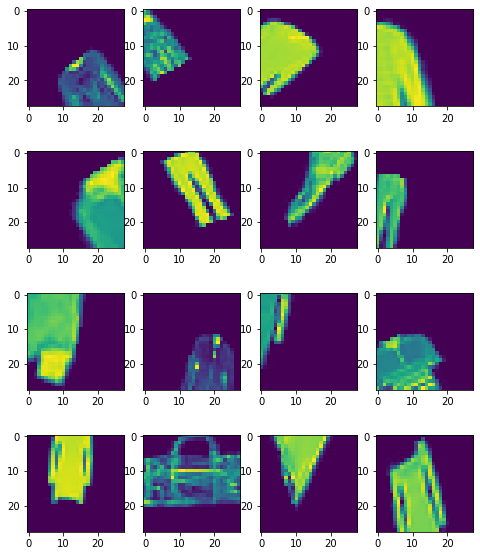

In [6]:
# lets just test how it works
# will just get a random batch from here (just pick the first one)
x_, y_ = datagen[1]
fig = plt.figure(figsize=[8, 10])
for i in range(0, 16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(x_[i, :,:,0])

As expected, our augmentation is a little extreme. 

We'll now confirm that we have two y outptus, i.e. two set of layers. In our case this should return the same set of labels twice.

In [7]:
print(y_)

[array([2, 3, 2, 6, 4, 1, 9, 1, 9, 4, 3, 0, 2, 8, 8, 3]), array([2, 3, 2, 6, 4, 1, 9, 1, 9, 4, 3, 0, 2, 8, 8, 3])]


## Using the DataGenerator in Model Training

We'll now train a simple model. This will be a very simple model, using a similar architecture to the second lecture example from week 10. Critically, it will have two outputs, but both outputs will be doing the same task. 

Again this isn't a demo of a proper model or multi-task learning. Is just here to demo that the image gen is working properly with multiple outputs.

In [8]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = layers.Flatten()(x)
x1 = layers.Dense(64, activation='relu')(x)
output_1 = layers.Dense(10, name='output1')(x1)
x2 = layers.Dense(64, activation='relu')(x)
output_2 = layers.Dense(10, name='output2')(x2)

model_cnn = keras.Model(inputs=inputs, outputs=[output_1, output_2], name='fmnist_dummy_model')
model_cnn.summary()

Model: "fmnist_dummy_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 8)    80          ['img[0][0]']                    
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 11, 11, 16)   1168        ['max_pooling2d[0][0]']          
                                                                                 

2022-05-30 13:45:57.725521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 13:45:57.730168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 13:45:57.730329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 13:45:57.730891: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

The key aprt now is that we pass to `fit` our data generator we created above, `datagen`.

Note that the validation data is not from a generator, but is the regular test set (with y_test duplicated for the two outputs.

In [9]:
model_cnn.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
              optimizer=keras.optimizers.RMSprop())
model_cnn.fit(datagen,
          epochs=10,
          validation_data=(x_test, [y_test, y_test]))

Epoch 1/10


2022-05-30 13:45:59.059963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-30 13:45:59.401739: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


187/187 [==============================] - 3s 8ms/step - loss: 4.5016 - output1_loss: 2.2528 - output2_loss: 2.2488 - val_loss: 4.0562 - val_output1_loss: 2.0275 - val_output2_loss: 2.0287
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 4.2880 - output1_loss: 2.1477 - output2_loss: 2.1404 - val_loss: 3.8793 - val_output1_loss: 1.9348 - val_output2_loss: 1.9445
Epoch 3/10
187/187 [==============================] - 1s 6ms/step - loss: 4.1670 - output1_loss: 2.0862 - output2_loss: 2.0808 - val_loss: 3.5738 - val_output1_loss: 1.8055 - val_output2_loss: 1.7683
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 4.0587 - output1_loss: 2.0313 - output2_loss: 2.0274 - val_loss: 3.5086 - val_output1_loss: 1.7662 - val_output2_loss: 1.7424
Epoch 5/10
187/187 [==============================] - 2s 8ms/step - loss: 3.9558 - output1_loss: 1.9814 - output2_loss: 1.9743 - val_loss: 3.2426 - val_output1_loss: 1.6303 - val_output2_loss: 1.6123
Epoch 6/10


We can see from above, our model trains. In this instance you really can ignore the losses - we're not training a serious model here (the data augmentation is too extreme, and we have the same task twice), but hopefully from the above you can see you could do this for real.

# Data Augmentation for Segmentation data and multi classification model


Want to create an dataset that will apply consistent augmentation to an input image
and the corresponding segmentation map (ie. if the image is rotated, rotate the segmentation map).

The following class implements this with the `tf.data.Dataset` objects, which are the newer methods
for loading in data in Tensorflow (the `ImageDataGenerator` is actually deprecated now and might be removed
sometime in the future). Within af `tf.data.Dataset` object, we can apply arbitrary python logic to a batch
by using the `.map()` method.


Hopefully you can see the logic of whats going on here, and how you could modify it for your tasks.


## NOTE: Need to install additional package for image rotations
Am using the `tensorflow_addons` package which includes additional things for tensorflow,
so will need to run something like

`pip install tensorflow_addons`


in your terminal, or you can try uncommenting and running the following cell to install it using the magic
commands for ipython

In [10]:
# !pip install tensorflow_addons

## SECOND NODE: This is not trivial
Reminder that for your assigment (A1C in 2022), you don't need to use the semantic segmentation data at all. Implementing this is a little bit more work, but I am hoping that for people who do want to implement it with semantic segmentation and the datau augmentation, you could use this as a template to get you going.

Here is the custom class I made which implements some of the functionality for data augmentation with the semantic segmentation data as well.
All the augmentation functionality is implemented in the `initialise_augmentation_operations` method. If you wanted to add additional augmentation, you could do so here following the style I have used.

In [11]:
# Class for the dataset which returns augmented images,
# augmented semantic segmentation data and class labels

import tensorflow_addons as tfa
import tensorflow as tf

class DatasetWithSegmentation():
    'Generates data for Keras'
    
    # Input arguments are as follows:
    #  x:            our X data array that we'll augment
    #  seg:          semantic segmentation data
    #  y_one:        y labels for the first output
    #  y_two:        y labels for the second ouput
    #  data_aug:     our data augmentor
    #  batch_size:   the batch size to return from the generator
    #  dim:          size of images
    #  n_channels:   number of image channels
    #  shuffle:      flag to indicate if we should shuffle the data at the end of the epoch
    #  rotation_range: int og degrees acceptable rotation for augmentation
    #                If is none, then wont do any random rotations
    # flip_lr:       Boolean to say if random flip_lr applied
    def __init__(self, x, seg, y_one, y_two,                 
                 batch_size=32, dim=(28,28), n_channels=1,
                 shuffle=True,
                 rotation_range=None,
                 flip_lr=False):
        # Saving class attributes
        # 
        # if shuffling, shuffle here
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = x.shape[0]
        self.rotation_range = rotation_range
        self.flip_lr = flip_lr
        self.dataset = tf.data.Dataset.from_tensor_slices((x, seg, y_one, y_two))
        # if shuffling, need to specify it here
        if self.shuffle:
            self.dataset.shuffle(buffer_size=self.num_samples)
        # this is a method that will add all the augmentation operations
        # we specified
        self.initialise_augmentation_operations()
        # perform batching here
        # by batching here, each individual input will have its
        # own augmentation params specified. Is more computationally expensive,
        # but will get more of the benefits of augmentation schemes
        self.dataset = self.dataset.batch(self.batch_size)
        # need to have clear separation between inputs and outputs, so
        # adding a function that will do that here
        def separate_inputs_outputs(image, segmentation_map, class_1, class_2):
            return image, (segmentation_map, class_1, class_2)
        self.dataset = self.dataset.map(separate_inputs_outputs)

        
    def initialise_augmentation_operations(self):
        # now specify additional augmentation argumentation operations here
        # if rotation_range is not None, then we specified we want to
        # do some random rotation
        if self.rotation_range is not None:
            # create the augmentation logic for rotation
            def rotation_fn(image, segmentation_map, class_1, class_2):
                # sample a rotation range to be applied to the image and segmentation
                print(image.shape)
                rot_deg = tf.random.uniform([1], minval=-self.rotation_range,
                                            maxval=self.rotation_range)
                # apply rotation to image and segmentation
                image = tfa.image.rotate(image, rot_deg)
                segmentation_map = tfa.image.rotate(segmentation_map, rot_deg)
                return image, segmentation_map, class_1, class_2
            # now apply (or map) the rotation data augmentation function
            self.dataset = self.dataset.map(rotation_fn)
            
        # now lets see about flip_lr
        if self.flip_lr:
            # create the augmentation logic for random flipping left or right
            def flip_lr_fn(image, segmentation_map, class_1, class_2):
                # sample a random integer of either zero or one
                # will flip with probability of 0.5
                flip_flag = tf.random.uniform([1], minval=0,maxval=1)
                # apply rotation to image and segmentation
                if tf.cast(flip_flag, tf.bool):
                    image = tf.image.flip_left_right(image)
                    segmentation_map = tf.image.flip_left_right(segmentation_map)
                return image, segmentation_map, class_1, class_2
            

            

In [12]:
seg_map = np.copy(x_train)
print(np.max(x_train))
# applying a gaussian blur here
# This will just try and fill in some of the holes in the images to create a more
# complete segmentation map when we threshold it
seg_map = tfa.image.gaussian_filter2d(seg_map).numpy()
#print(seg_map)
seg_map[seg_map < 0.05] = 0
seg_map[seg_map >0] = 1




1.0


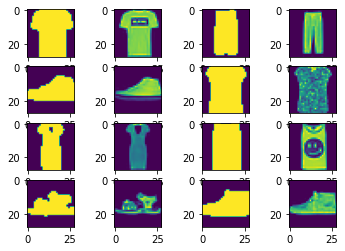

In [13]:
# plotting some of them
fig = plt.figure()
for i in range(0, 8):
    ax = fig.add_subplot(4, 4, i * 2 + 1)
    ax.imshow(seg_map[i, :,:,0])
    ax = fig.add_subplot(4, 4, i * 2 + 2)
    ax.imshow(x_train[i, :,:,0])

In [14]:
custom_dataset = DatasetWithSegmentation(x_train, seg_map, y_train, y_train,                 
                                         batch_size=32, dim=(28,28), n_channels=1,
                                         shuffle=True,
                                         rotation_range=45,
                                         flip_lr=True)

(28, 28, 1)


In [15]:
# want to create an iterator of it now just so I can plot]
# some of the samples and check its all working
data_iter = iter(custom_dataset.dataset)
x = next(data_iter)
print(len(x))
print(x[0].shape)
print(x[1][0].shape)
print(x[1][1].shape)
print(x[1][2].shape)

2
(32, 28, 28, 1)
(32, 28, 28, 1)
(32, 1)
(32, 1)


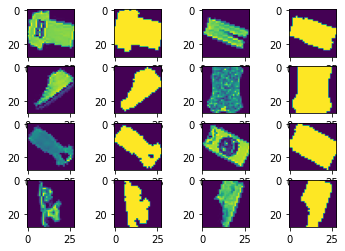

In [16]:
fig = plt.figure()
im = x[0]
seg = x[1][0]
for i in range(0, 8):
    ax = fig.add_subplot(4, 4, i * 2 + 1)
    ax.imshow(im[i, :,:, :])
    ax = fig.add_subplot(4, 4, i * 2 + 2)
    ax.imshow(seg[i, :, :,:])

In [17]:
# creating a model now for multi task classification and semantic segmentation
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
encoded = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu')(x)
encoded_flat = layers.Flatten()(encoded)
x1 = layers.Dense(64, activation='relu')(encoded_flat)
output_1 = layers.Dense(10, name='output1')(x1)
x2 = layers.Dense(64, activation='relu')(encoded_flat)
output_2 = layers.Dense(10, name='output2')(x2)

x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(encoded)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same',activation='relu')(x)
# note that the number of filters here is (1), because the number of classes in this
# toy semantic segmentation model is two (either object is here or it isn't, is a binary problem)
# For this reason we are using the Sigmoid activation (essentially pixelwise binary classification).
# For more classes, will need to change the number of filters and use the softmax activation.
# Refer to the lecture examples for more info
decoded = layers.Conv2D(filters=1, kernel_size=(3,3), padding='same',activation='sigmoid', name='segmentation')(x)

# multi classification and segmentation model
model_cnn = keras.Model(inputs=inputs, outputs=[decoded, output_1, output_2], name='fmnist_dummy_model')
model_cnn.summary()

Model: "fmnist_dummy_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 8)    80          ['img[0][0]']                    
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 8)   0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 16)   1168        ['max_pooling2d_2[0][0]']        
                                                                                 

Lets compile the model now and fit it and see how we go.

In [18]:
# In the lecture examples we used the focal loss, but here I am going to use just the binary cross entropy,
# as class imbalance is not a big issue here (also this is just for demo purposes)
# Note that I am setting `from_logits` to False for the segmentation loss, because I explicitly
# set the output activation to be a sigmoid earlier in the model (which converted the logits to a binary/Bernoulli probability)

model_cnn.compile(loss=[keras.losses.BinaryCrossentropy(from_logits=False),
                        keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
              optimizer=keras.optimizers.Adam())

model_cnn.fit(custom_dataset.dataset,
              epochs=50)

Epoch 1/50
94/94 [==============================] - 1s 5ms/step - loss: 4.0371 - segmentation_loss: 0.3134 - output1_loss: 1.8670 - output2_loss: 1.8566
Epoch 2/50
94/94 [==============================] - 0s 3ms/step - loss: 2.9797 - segmentation_loss: 0.1487 - output1_loss: 1.4092 - output2_loss: 1.4217
Epoch 3/50
94/94 [==============================] - 0s 3ms/step - loss: 2.6464 - segmentation_loss: 0.1259 - output1_loss: 1.2525 - output2_loss: 1.2681
Epoch 4/50
94/94 [==============================] - 0s 3ms/step - loss: 2.4367 - segmentation_loss: 0.1131 - output1_loss: 1.1530 - output2_loss: 1.1705
Epoch 5/50
94/94 [==============================] - 0s 3ms/step - loss: 2.2661 - segmentation_loss: 0.1055 - output1_loss: 1.0727 - output2_loss: 1.0879
Epoch 6/50
94/94 [==============================] - 0s 3ms/step - loss: 2.1575 - segmentation_loss: 0.0999 - output1_loss: 1.0218 - output2_loss: 1.0359
Epoch 7/50
94/94 [==============================] - 0s 3ms/step - loss: 2.0646 - s

Lets plot some of the results now and see how we went.
I can create a new dataset for the testing data that doesn't apply any augmentation, and feed that
straight into the predict function of the model.

In [19]:
# creating segmentation maps for the testing data
seg_map_test = np.copy(x_test)
# applying a gaussian blur here
# This will just try and fill in some of the holes in the images to create a more
# complete segmentation map when we threshold it
seg_map_test = tfa.image.gaussian_filter2d(seg_map_test).numpy()
seg_map_test[seg_map_test < 0.05] = 0
seg_map_test[seg_map_test >0] = 1
# create the dataset object
# i defined all augmentation values to be False/None by default
dataset_test = DatasetWithSegmentation(x_test, seg_map_test, y_test, y_test,                 
                                       batch_size=32, dim=(28,28), n_channels=1)


In [20]:
pred_seg, pred_class_one, pred_class_two = model_cnn.predict(dataset_test.dataset)


In [21]:
# should be very, very, very similar performance here, as essentially doing the same thing
print('classification accuracy first task = {}'.format(accuracy_score(y_test, np.argmax(pred_class_one, axis=1))))
print('classification accuracy second task = {}'.format(accuracy_score(y_test, np.argmax(pred_class_two, axis=1))))

classification accuracy first task = 0.76
classification accuracy second task = 0.7511


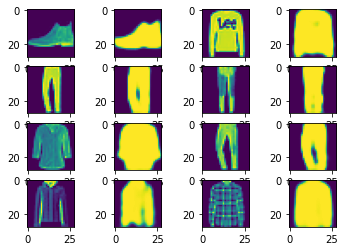

In [22]:
# what about the segmentation maps?
fig = plt.figure()
im = x[0]
seg = x[1][0]
for i in range(0, 8):
    ax = fig.add_subplot(4, 4, i * 2 + 1)
    ax.imshow(x_test[i, :,:, :])
    ax = fig.add_subplot(4, 4, i * 2 + 2)
    ax.imshow(pred_seg[i, :, :,:])


looks pretty good to me. Hopefully this gives you an idea of how you can apply augmentation to multi task model with semantic segmenation data. And remember some of the augmentation params I have used are extreme (eg. rotation range of 45 degrees is a bit much).